## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

## First: camera calibration using chessboard images
This is a one-time cost so better do it separately from the rest of the pipeline

In [3]:
### parameters
nx=9
ny=6
#Calibrate camera
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img,(nx,ny), corners, ret)
cv2.destroyAllWindows()
 
#extract camera matrix 1 distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

## Second: Image pipeline

### Helper functions

In [12]:
#1. Correct distortion : no function
#2. Create binary threshold image
def create_binary(img, lthd=(170, 255), bthd=(20, 100),sthd=(80,100)):
    def bin_it(image, threshold):
        output_bin = np.zeros_like(image)
        output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1
        return output_bin

    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2] # for yellow lanes
    l_channel = lab[:,:,0] # for white lanes
    s_channel = hls[:,:,2]
    
    l_channel = l_channel*(255/np.max(l_channel))
    l_output = np.zeros_like(l_channel)
    l_output[(l_channel > lthd[0]) & (l_channel <= lthd[1])] = 1
    
    s_channel = s_channel*(255/np.max(s_channel))
    s_output = np.zeros_like(l_channel)
    s_output[(s_channel > sthd[0]) & (s_channel <= sthd[1])] = 1
    
    if np.max(b_channel) > 175:
        b_channel = b_channel*(255/np.max(b_channel))
    b_output = np.zeros_like(b_channel)
    b_output[((b_channel > bthd[0]) & (b_channel <= bthd[1]))] = 1
    
    color_binary=np.zeros_like(b_channel)
    color_binary[(b_output==1) | (l_output==1)]=1
    return color_binary

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#3. Warp image
def transform_perspective(img,src,offset=20):
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]-offset], 
                    [offset, img_size[1]-offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img, M, Minv

#4. Detect lane lines in the image
def find_lane_lines(img,nwindows,margin,minpix):
    
    histogram=np.sum(img[int(img.shape[0]/2):img.shape[0],:],0)
    mid_point=int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:mid_point])
    rightx_base=np.argmax(histogram[mid_point:])+mid_point
    #print(mid_point,leftx_base,rightx_base)
    #x,y positions for non zero pixels
    window_height=img.shape[0]//nwindows
    non_zero=img.nonzero()
    non_zerox=np.array(non_zero[1])
    non_zeroy=np.array(non_zero[0])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # track curvature by iterating through nwindows
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        #Identify the nonzero pixels in x and y within the window
        good_left_inds = ((non_zeroy >= win_y_low) & (non_zeroy <= win_y_high) &
                          (non_zerox >=  win_xleft_low) & (non_zerox <= win_xleft_high))
        good_left_inds=np.where(good_left_inds !=0)[0]
        good_right_inds = ((non_zeroy >= win_y_low) & (non_zeroy <= win_y_high) &
                           (non_zerox >=  win_xright_low) & (non_zerox <= win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds)>minpix:
            leftx_current=np.int(np.mean(non_zerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(non_zerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    leftx = non_zerox[left_lane_inds]
    lefty = non_zeroy[left_lane_inds] 
    rightx = non_zerox[right_lane_inds]
    righty = non_zeroy[right_lane_inds]
    left_found=len(lefty)>0
    right_found=len(righty)>0
    if len(lefty)>5*len(righty):
        right_found=False
    if len(righty)>5*len(lefty):
        left_found=False
    return leftx,lefty,rightx,righty,left_found,right_found

#5. Fit lane lines to the picture
def fit_lane_lines(img,leftx,lefty,rightx,righty,left_found,right_found,ratio,smoothing=False,xm=np.float32(3.7/700),ym=np.float32(30/720)):
    left_fitx=np.copy(tracker.leftFit)
    right_fitx=np.copy(tracker.rightFit)
    left_fit=np.array([])
    right_fit=np.array([])
    out_img = np.dstack((img,img,img))
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    good_fit_left=False
    good_fit_right=False
    Rright=np.float(0)
    Rleft=np.float(0)
    alpha=0.25
    ###1. Check if fits are good 
    if (right_found is True):
        right_fit = np.polyfit(righty,rightx,2)
        try:
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            right_fitx = 1*ploty**2 + 1*ploty
        Rright=compute_curvature(img.shape[0],righty,rightx,xm,ym)
        sameRadius=np.abs(Rright-tracker.roadCurve)<alpha*np.max((tracker.roadCurve,Rright))
        if (tracker.init is True):
            sameRadius=True
        if(sameRadius):
            good_fit_right=True
    if (left_found is True):
        left_fit = np.polyfit(lefty,leftx,2)
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
        Rleft=compute_curvature(img.shape[0],lefty,leftx,xm,ym)
        sameRadius=np.abs(Rleft-tracker.roadCurve)<alpha*np.max((tracker.roadCurve,Rleft))
        if (tracker.init is True):
            sameRadius=True
        if(sameRadius):
            good_fit_left=True
    if ((good_fit_left is True) and (good_fit_right is True)):
        l1=len(righty)
        l2=len(lefty)
        sigma=np.float64
        sigma=np.abs(left_fit[0]-right_fit[0])/np.max((np.abs(left_fit[0]),np.abs(right_fit[0])))
        if((sigma>alpha)& (l1>l2)):
            good_fit_left=False
        if((sigma>alpha) & (l2>l1)):
            good_fit_right=False
        dist=np.abs(lefty-np.max(righty))
        min_pos=np.argmin(dist)
        width=rightx[np.argmax(righty)]-leftx[min_pos]
        if(np.abs(width-tracker.roadWidth)>0.1*tracker.roadWidth):
            if(l1>l2):
                good_fit_left=False
            if(l2>l1):
                good_fit_right=False
    ###2. Deciding curvature + lanes values based on fit quality
    #scenario 1: no good fits: Handled by initialization
    #scenario 2: Left good fit
    if ((good_fit_left is True) and (good_fit_right is False)):
        right_fit=np.copy(left_fit)
        right_fit[2]=right_fit[2]+tracker.roadWidth
#         if(len(rightx)==0):
#             right_fit[2]=right_fit[2]+tracker.roadWidth
#         if(len(rightx)>0):
#             dist=np.abs(lefty-np.max(righty))
#             min_pos=np.argmin(dist)
#             width=rightx[np.argmax(righty)]-leftx[min_pos]
#             #tracker.roadWidth=0.99*width+0.01*tracker.roadWidth
#             right_fit[2]=right_fit[2]+width
        right_fitx=right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        tracker.leftFit=np.copy(left_fitx)
        tracker.rightFit=np.copy(right_fitx)
        tracker.roadCurve=0.05*tracker.roadCurve+0.95*Rleft
        if (tracker.init is True):
            tracker.roadCurve=Rleft
    #scenario 3: Right good fit
    if ((good_fit_right is True) and (good_fit_left is False)):
        left_fit=np.copy(right_fit)
        left_fit[2]=left_fit[2]+tracker.roadWidth
#         if(len(leftx)==0):
#             left_fit[2]=left_fit[2]+tracker.roadWidth
#         if(len(leftx)>0):
#             dist=np.abs(righty-np.max(lefty))
#             min_pos=np.argmin(dist)
#             width=rightx[min_pos]-leftx[np.argmax(lefty)]
#             #tracker.roadWidth=0.99*width+0.01*tracker.roadWidth
#             tracker.drift=(rightx[min_pos]+leftx[np.argmax(lefty)]-img.shape[1])*xm/2
#             left_fit[2]=left_fit[2]-width
        left_fitx=left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        tracker.rightFit=np.copy(right_fitx)
        tracker.leftFit=np.copy(left_fitx)
        tracker.roadCurve=0.05*tracker.roadCurve+0.95*Rright
        if (tracker.init is True):
            tracker.roadCurve=Rright
    #scenario 4: Right+Left good fit
    if ((good_fit_right is True) and (good_fit_left is True)):
#         #check for straight line to update road width information
#         if ((np.abs(left_fit[0])<0.5*1e-4) & (np.abs(right_fit[0])<0.5*1e-4)): 
#             dist=np.abs(righty-np.max(lefty))
#             min_pos=np.argmin(dist)
#             width=rightx[min_pos]-leftx[np.argmax(lefty)]
#             #tracker.roadWidth=0.99*width+0.01*tracker.roadWidth
        #update road curvature info with 95% certainty
        tracker.roadCurve=(Rright+Rleft)/2
        tracker.leftFit=left_fitx
        tracker.rightFit=right_fitx
    tracker.init=False
    ###3. Plot points and text
    leftFit=left_fitx
    rightFit=right_fitx
    tracker.recentLefts.append(left_fitx)
    tracker.recentRights.append(right_fitx)
    if(smoothing & len(tracker.recentRights)>1):
        if(len(tracker.recentRights)>5):
            tracker.recentRights.pop(0)
            tracker.recentLefts.pop(0)
        leftFit=np.mean(tracker.recentLefts, axis=0)
        rightFit=np.mean(tracker.recentRighs, axis=0)
    pts_left = np.array([np.transpose(np.vstack([leftFit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightFit, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
    return out_img

#6. Compute curvature & vehicle position
def compute_curvature(imY,ypix,xpix,xm,ym):
    R=np.float32(0)
    ploty = np.linspace(0, imY-1, imY)
    y_eval = np.max(ploty)
    fit = np.polyfit(ypix*ym, xpix*xm, 2)
    R = ((1 + (2*fit[0]*y_eval*ym + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return R
#7. Unwarp: no function 
#8. Output result
def weighted_img(img, initial_img, α=0.8, β=0.7, γ=0):
    font = cv2.FONT_HERSHEY_COMPLEX
    curve_text = 'Road curvature=' + str(np.round(tracker.roadCurve,2))+ 'm, Drift='+str(np.round(tracker.drift,2))+'m'
    cv2.putText(initial_img, curve_text, (30, 60), font, 1, (0,0,0), 2)
    return cv2.addWeighted(initial_img, α, np.uint8(img), β, γ)

### Assumed constants

In [24]:
### Source points: reference points coordinates
srcpt_project=np.float32([[555,480],[733,480],[1020,660],[300,660]])
srcpt_challenge=np.float32([[568,523],[756,523],[978,694],[328,694]])
srcpt_hard=np.float32([[452,560],[800,560],[947,678],[274,678]])
### Road widths in pixels in the projected image
road_width_project=np.float64(1037)
road_width_challenge=np.float64(1048)
road_width_hard=np.float64(1100)

### Tracker class

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.init=True
        self.leftFit = [] # x values of the previous left lane
        self.rightFit = [] # x values of the previous right lane
        self.roadCurve= np.float64(800) #road curvature in meters
        self.roadWidth=road_width_project #road width in pixels in the projected image
        self.drift=0 #car position w.r.t center
        self.recentLefts=[] #list of recent left fits
        self.recentRights=[] #list of recent right fits


### Pipeline function

In [20]:
def image_pipeline(img):
    imsize=(img.shape[1],img.shape[0])
    #### Parameters list
    #Camera params (loaded in 1st part): nx,ny,mtx,dist,rvecs,tvecs
    #distortion: no parameters
    #binary threshold image:
    sthd=(120,150)
    lthd=(200,255)
    bthd=(200,255)
    #gaussian filter
    kernelSize=3
    #warp/unwarp image:
    offset=100
    src=srcpt_project
    ratio=img.shape[1]/(src[2][0]-src[3][0])
    #detect/fit lane lines
    nwindows = 6
    margin = 150 
    minpix = 100
    margin2=100 #margin value for search around existing poly
    smooth=True
    
    #undistort image
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #convert image to binary
    bin_im=create_binary(undst,lthd,bthd,sthd)
    #Apply gaussian filter
    blurred=gaussian_blur(bin_im,kernelSize)
    #transform perspective
    warped,M,Minv=transform_perspective(bin_im,src,offset)
    #find lane lines
    leftx,lefty,rightx,righty,left_found,right_found=find_lane_lines(warped,nwindows,margin,minpix)
    #fit lane lines
    out_img=fit_lane_lines(warped,leftx,lefty,rightx,righty,left_found,right_found,ratio,smooth)
    #unwarp
    unwarped=cv2.warpPerspective(out_img, Minv, imsize)
    #restor background
    res=weighted_img(np.uint8(unwarped),img)
    return res

### Convert png images (from video) to jpg

In [6]:
# imname='test_images/harder_video0.png'
# image = cv2.imread(imname)
# cv2.imwrite(imname[:-3] + 'jpg', image)

True

### Finding source points

<IPython.core.display.Javascript object>


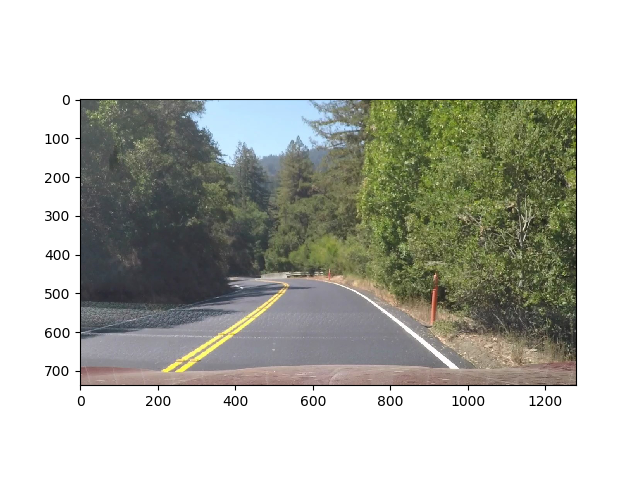

In [8]:
# image = mpimg.imread('test_images/harder_video0.jpg')
# plt.imshow(image)

### Parameters tuning

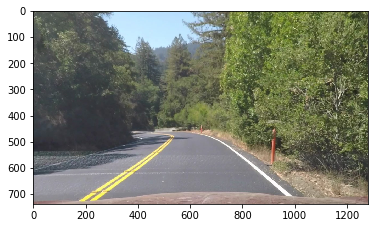

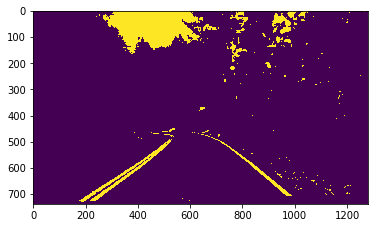

1100


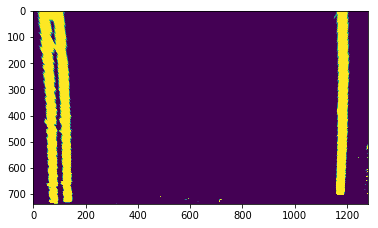

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


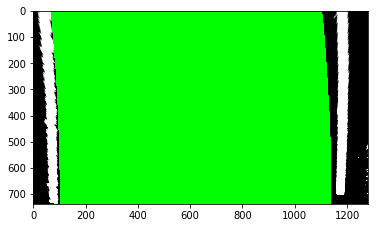

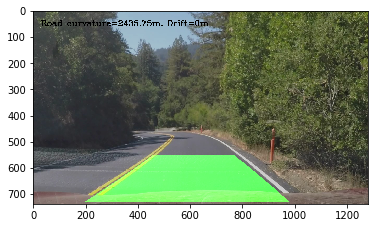

In [11]:
%matplotlib inline
tracker=Line()
imname='test_images/harder_video0.jpg'
image = mpimg.imread(imname)

undst_im = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(undst_im)
plt.show()

sthd=(120,150)
lthd=(200,255)
bthd=(200,255)
cx_image = create_binary(undst_im,lthd,bthd,sthd)
plt.imshow(cx_image)
plt.show()

blurred=gaussian_blur(cx_image,3)
#plt.show()
#plt.imshow(blurred)
srcpt=srcpt_project

ratio=image.shape[1]/(srcpt[2][0]-srcpt[3][0])
smooth=False
ww,mm,mminv=transform_perspective(cx_image,srcpt,100)
plt.show()
plt.imshow(ww)
leftx,lefty,rightx,righty,left_found,right_found=find_lane_lines(ww,9,150,100)

out_i=fit_lane_lines(ww,leftx,lefty,rightx,righty,left_found,right_found,ratio,smooth)
plt.show()
plt.imshow(out_i)
unw=cv2.warpPerspective(out_i, mminv, (image.shape[1],image.shape[0]))
plt.show()
#plt.imshow(unw)

rer=weighted_img(np.uint8(unw),image)

plt.show()
plt.imshow(rer)

### Pipeline

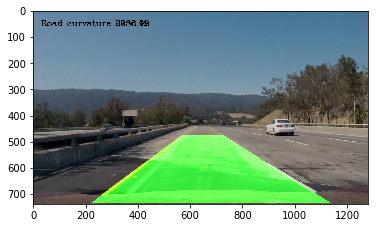

In [164]:
im=image_pipeline(image)
%matplotlib inline
plt.imshow(im)
plt.savefig(imname.replace('test_images','output_images'))

## Third: Video pipeline

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
tracker=Line()
white_output = 'output_videos/challenge_video2.mp4'
#clip1 = VideoFileClip("test_videos/project_video.mp4").subclip(0,10)
clip1 = VideoFileClip("test_videos/harder_challenge_video.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video2.mp4
[MoviePy] Writing video output_videos/challenge_video2.mp4



 13%|█▎        | 152/1200 [00:32<03:46,  4.63it/s]


 25%|██▌       | 303/1200 [01:11<03:31,  4.24it/s]


 38%|███▊      | 454/1200 [01:52<03:04,  4.04it/s]


 50%|█████     | 605/1200 [02:26<02:24,  4.12it/s]


 63%|██████▎   | 756/1200 [03:07<01:49,  4.04it/s]


 76%|███████▌  | 907/1200 [03:51<01:14,  3.91it/s]


 88%|████████▊ | 1057/1200 [04:29<00:36,  3.92it/s]


100%|█████████▉| 1199/1200 [05:09<00:00,  3.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video2.mp4 

CPU times: user 8min 16s, sys: 1min 17s, total: 9min 34s
Wall time: 5min 12s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))